In [2]:
import pickle
import hdbscan
from module.module import *
from matplotlib import font_manager, rc

plt.rcParams['axes.unicode_minus'] = False
rc('font', family='AppleGothic')
pd.set_option('display.max_columns', None)

In [3]:
# Test를 위해 미드 중 랜덤샘플링에 사용
with open('datas/position/MID_for_model.pkl', 'rb') as f:
    mid_df = pickle.load(f)

# 특정 플레이시간에 오브젝트 관여의 중요도를 보여주는 것에 사용
with open('datas/team_2_for_model.pkl', 'rb') as f:
    team_2_df = pickle.load(f)

# 특정 플레이시간, 오브젝트에 대해 포지션별 승률이 높은 TOP2 챔피언 추천에 사용
with open('datas/recommendation_obj_for_model', 'rb') as f:
    reco_obj_df = pickle.load(f)
    
# 군집예측을 위해 랜덤샘플링된 데이터와 매칭할 때 사용
with open('datas/pca_tsne_mid.pkl', 'rb') as f:
    tsne_data = pickle.load(f)
    
# 군집예측을 위해 tsne된 데이터를 학습시킨 모델
with open('models/hdbscan_obj.pkl', 'rb') as f:
    hdb_model = pickle.load(f)
    
# 군집별 출현빈도에 대한 데이터
with open('datas/label_score.pkl', 'rb') as f:
    label_score = pickle.load(f)

# 군집별 TOP3 챔피언 추천에 사용
with open('datas/position/la_mid_for_model.pkl', 'rb') as f:
    la_mid_df = pickle.load(f)

#### 랜덤샘플링을 위한 10개의 인덱스 추출

In [201]:
np.random.seed(30)
random_idx = np.random.choice(mid_df.index, size=10)
random_idx

array([ 48045,  46220, 328599, 222339, 108969, 311559,   3905, 168625,
       317357, 163261])

#### 미드에서 랜덤샘플링 및 표본평균 추출

In [202]:
samples = mid_df.loc[random_idx]
s_time = np.mean(samples["gameduration"])
print(f'Samples Mean gameduraion : {np.round(s_time, 2)}')

Samples Mean gameduraion : 26.47


#### 표본 평균에 대한 기준 플레이 시간 정의

In [203]:
if s_time >= 40:
    data = team_2_df[team_2_df['gameduration'] >= 2400]
    criteria = "40분 이상"
    duration1, duration2 = 2400, None
elif s_time >= 30:
    data = team_2_df[(team_2_df['gameduration'] >=1800) & (team_2_df['gameduration'] < 2400)]
    criteria = "30~40분"
    duration1, duration2 = 1800, 2400
elif s_time >= 20:
    data = team_2_df[(team_2_df['gameduration'] >=1200) & (team_2_df['gameduration'] < 1800)]
    criteria = "20~30분"
    duration1, duration2 = 1200, 1800
else:
    data = team_2_df[team_2_df['gameduration'] < 1200]
    criteria = "20분 미만"
    duration1, duration2 = 1200, None
    
print(criteria, duration1, duration2)

20~30분 1200 1800


#### 표본의 기준 플레이시간에 대한 오브젝트 중요도 정보 제공

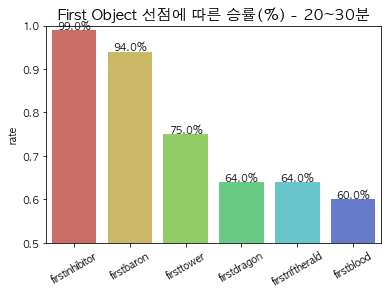

In [204]:
show_rateplot(data, criteria)

#### 표본의 기준 플레이시간에서 첫 억제기 파괴관여하고 이긴 포지션 및 TOP2 챔피언 정보 제공

In [205]:
recommendation_obj(reco_obj_df, 'firstinhibitor', duration1, duration2)

ADC의 firstinhibitor 기여도: 22.06%
ADC 중 TOP2 Champion: Ezreal(17.96%), Caitlyn(12.56%)
--------------
JUNGLE의 firstinhibitor 기여도: 19.57%
JUNGLE 중 TOP2 Champion: LeeSin(9.43%), Nidalee(8.6%)
--------------
MID의 firstinhibitor 기여도: 18.62%
MID 중 TOP2 Champion: Sylas(5.63%), Akali(5.54%)
--------------
SUPPORT의 firstinhibitor 기여도: 21.57%
SUPPORT 중 TOP2 Champion: Thresh(9.58%), Lulu(7.56%)
--------------
TOP의 firstinhibitor 기여도: 18.19%
TOP 중 TOP2 Champion: Camille(6.64%), Renekton(5.68%)
--------------


#### 랜덤샘플링 인덱스를 tsne 데이터와 매칭 후 HDBSCAN모델을 사용한 군집예측

In [206]:
tsne_samples = tsne_data[random_idx]

s_labels, strengths = hdbscan.approximate_predict(hdb_model, tsne_samples)
s_labels

array([7, 7, 0, 7, 7, 6, 7, 7, 7, 7])

#### 뽑힌 군집과 해당 군집의 출현빈도에 대한 데이터로 정리

In [207]:
unique_label, counts = np.unique(s_labels, return_counts=True)
result = dict(zip(unique_label, counts / counts.sum()))
print(result)

{0: 0.1, 6: 0.1, 7: 0.8}


In [4]:
label_score

{0: 0.00409136995288364,
 1: 0.00837657303035725,
 2: 0.015065306852746466,
 3: 0.006426313592175106,
 4: 0.10475040257648953,
 5: 0.02067453927357309,
 6: 0.010792031967555318,
 7: 0.8298234627542196}

#### 표본의 출현빈도와 군집의 점수를 통한 점수계산

In [208]:
result_score = {}
for k, v in result.items():
    try:
        result_score[k] = v / label_score[k]
    except:
        continue

result_score

{0: 24.44169096209913, 6: 9.266095606521139, 7: 0.9640604729887557}

#### 표본의 군집 예측

In [209]:
s_cluster = list(result_score.keys())[np.argmax(list(result_score.values()))]
s_cluster

0

#### 예측된 군집에서의 TOP3 챔피언 정보 제공

In [210]:
show_champion_label(la_mid_df, s_cluster)

Cluster_0 중 Pick Rate TOP3 >> Yasuo(9.55%), Yone(8.53%), Talon(6.92%)


```
Best 1 : 적 정글 중립미니언킬, 오브젝트에 가한 피해량, 타워킬, 골드획득, 총 중립미니언킬
        , 포탑에 가한 피해량, CS수
Best 2 : 총 가한 군중제어 시간
Worst 1 : -
Worst 2 : 와드 제거 수, 시야점수, 적에게 가한 CC시간
```
- 다른 군집에 비해 포탑 및 오브젝트의 관여도가 높으며, CS수가 높습니다.
- 다른 군집에 비해 와드제거 및 시야점수가 낮으며 적에게 가하는 CC시간이 적습니다.
- 부족한 특징 중 시야점수를 우선적으로 높인다면 이길 확률이 더욱 더 높아질 수 있습니다.